## **Varying Class Images - Check Activations**
- Feed All Images Thru Network, Recording Activations
- Plot Histogram of Activations, Find Most Exciting Class

In [167]:
# Externals
import os
import sys
import ast
import PIL
import torch
import random
import scipy.io
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
from collections import defaultdict
from torchsummary import summary
from torchvision.models import vgg16, VGG16_Weights
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from torchvision import transforms

In [168]:
# Check Version, GPU Devices
print('Torch Version:', torch.__version__)
if torch.cuda.is_available():
    for i in range(torch.cuda.device_count()):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)} (Memory: {torch.cuda.get_device_properties(i).total_memory / 1e9} GB)")
else:
    print("No GPU Available")

Torch Version: 2.1.2+cu118
GPU 0: NVIDIA A100-SXM4-80GB (Memory: 84.989575168 GB)
GPU 1: NVIDIA A100-SXM4-80GB (Memory: 84.989575168 GB)
GPU 2: NVIDIA A100-SXM4-80GB (Memory: 84.989575168 GB)
GPU 3: NVIDIA A100-SXM4-80GB (Memory: 84.989575168 GB)
GPU 4: NVIDIA A100-SXM4-80GB (Memory: 84.989575168 GB)
GPU 5: NVIDIA A100-SXM4-80GB (Memory: 84.989575168 GB)
GPU 6: NVIDIA A100-SXM4-80GB (Memory: 84.989575168 GB)
GPU 7: NVIDIA A100-SXM4-80GB (Memory: 84.989575168 GB)


In [170]:
# Force Torch Home, Set Device
os.environ['TORCH_HOME'] = './TORCH_HOME'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Shove Model Into Device UwU (*Plort*)
model = models.vgg16(pretrained = True).to(device)
model.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [181]:
# Custom Dataset Class
class ImageNetDataset(Dataset):
    def __init__(self, root_dir, transform = None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = [os.path.join(dp, f) for dp, dn, filenames in os.walk(root_dir) for f in filenames if f.endswith('.JPEG')]
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image

# Image Transformations
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(256),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]),
])

# Dataset, DataLoader
root_dir = '/users/tdohm/work/Imagenet'
imagenet_dataset = ImageNetDataset(root_dir = root_dir, transform = transform)
data_loader = DataLoader(imagenet_dataset, batch_size = 10, shuffle = True)

# Define Forward Hook To Capture Activations
activations = {}
def get_activation(name):
    def hook(model, input, output):
        activations[name] = output.detach()
    return hook

# Attach Hook
layer_name = 'features.3'
getattr(model, layer_name.split('.')[0])[int(layer_name.split('.')[1])].register_forward_hook(get_activation(layer_name))

# Processing Images, Capturing Activations
for i, images in enumerate(data_loader):
    images = images.to(device)
    output = model(images)
    
    # Example Of Activations
    current_activation = activations[layer_name]
    print(f"Batch {i + 1}, Activation Shape: {current_activation.shape}")

    # Stop After Iteration
    break

Batch 1, Activation Shape: torch.Size([10, 64, 256, 256])


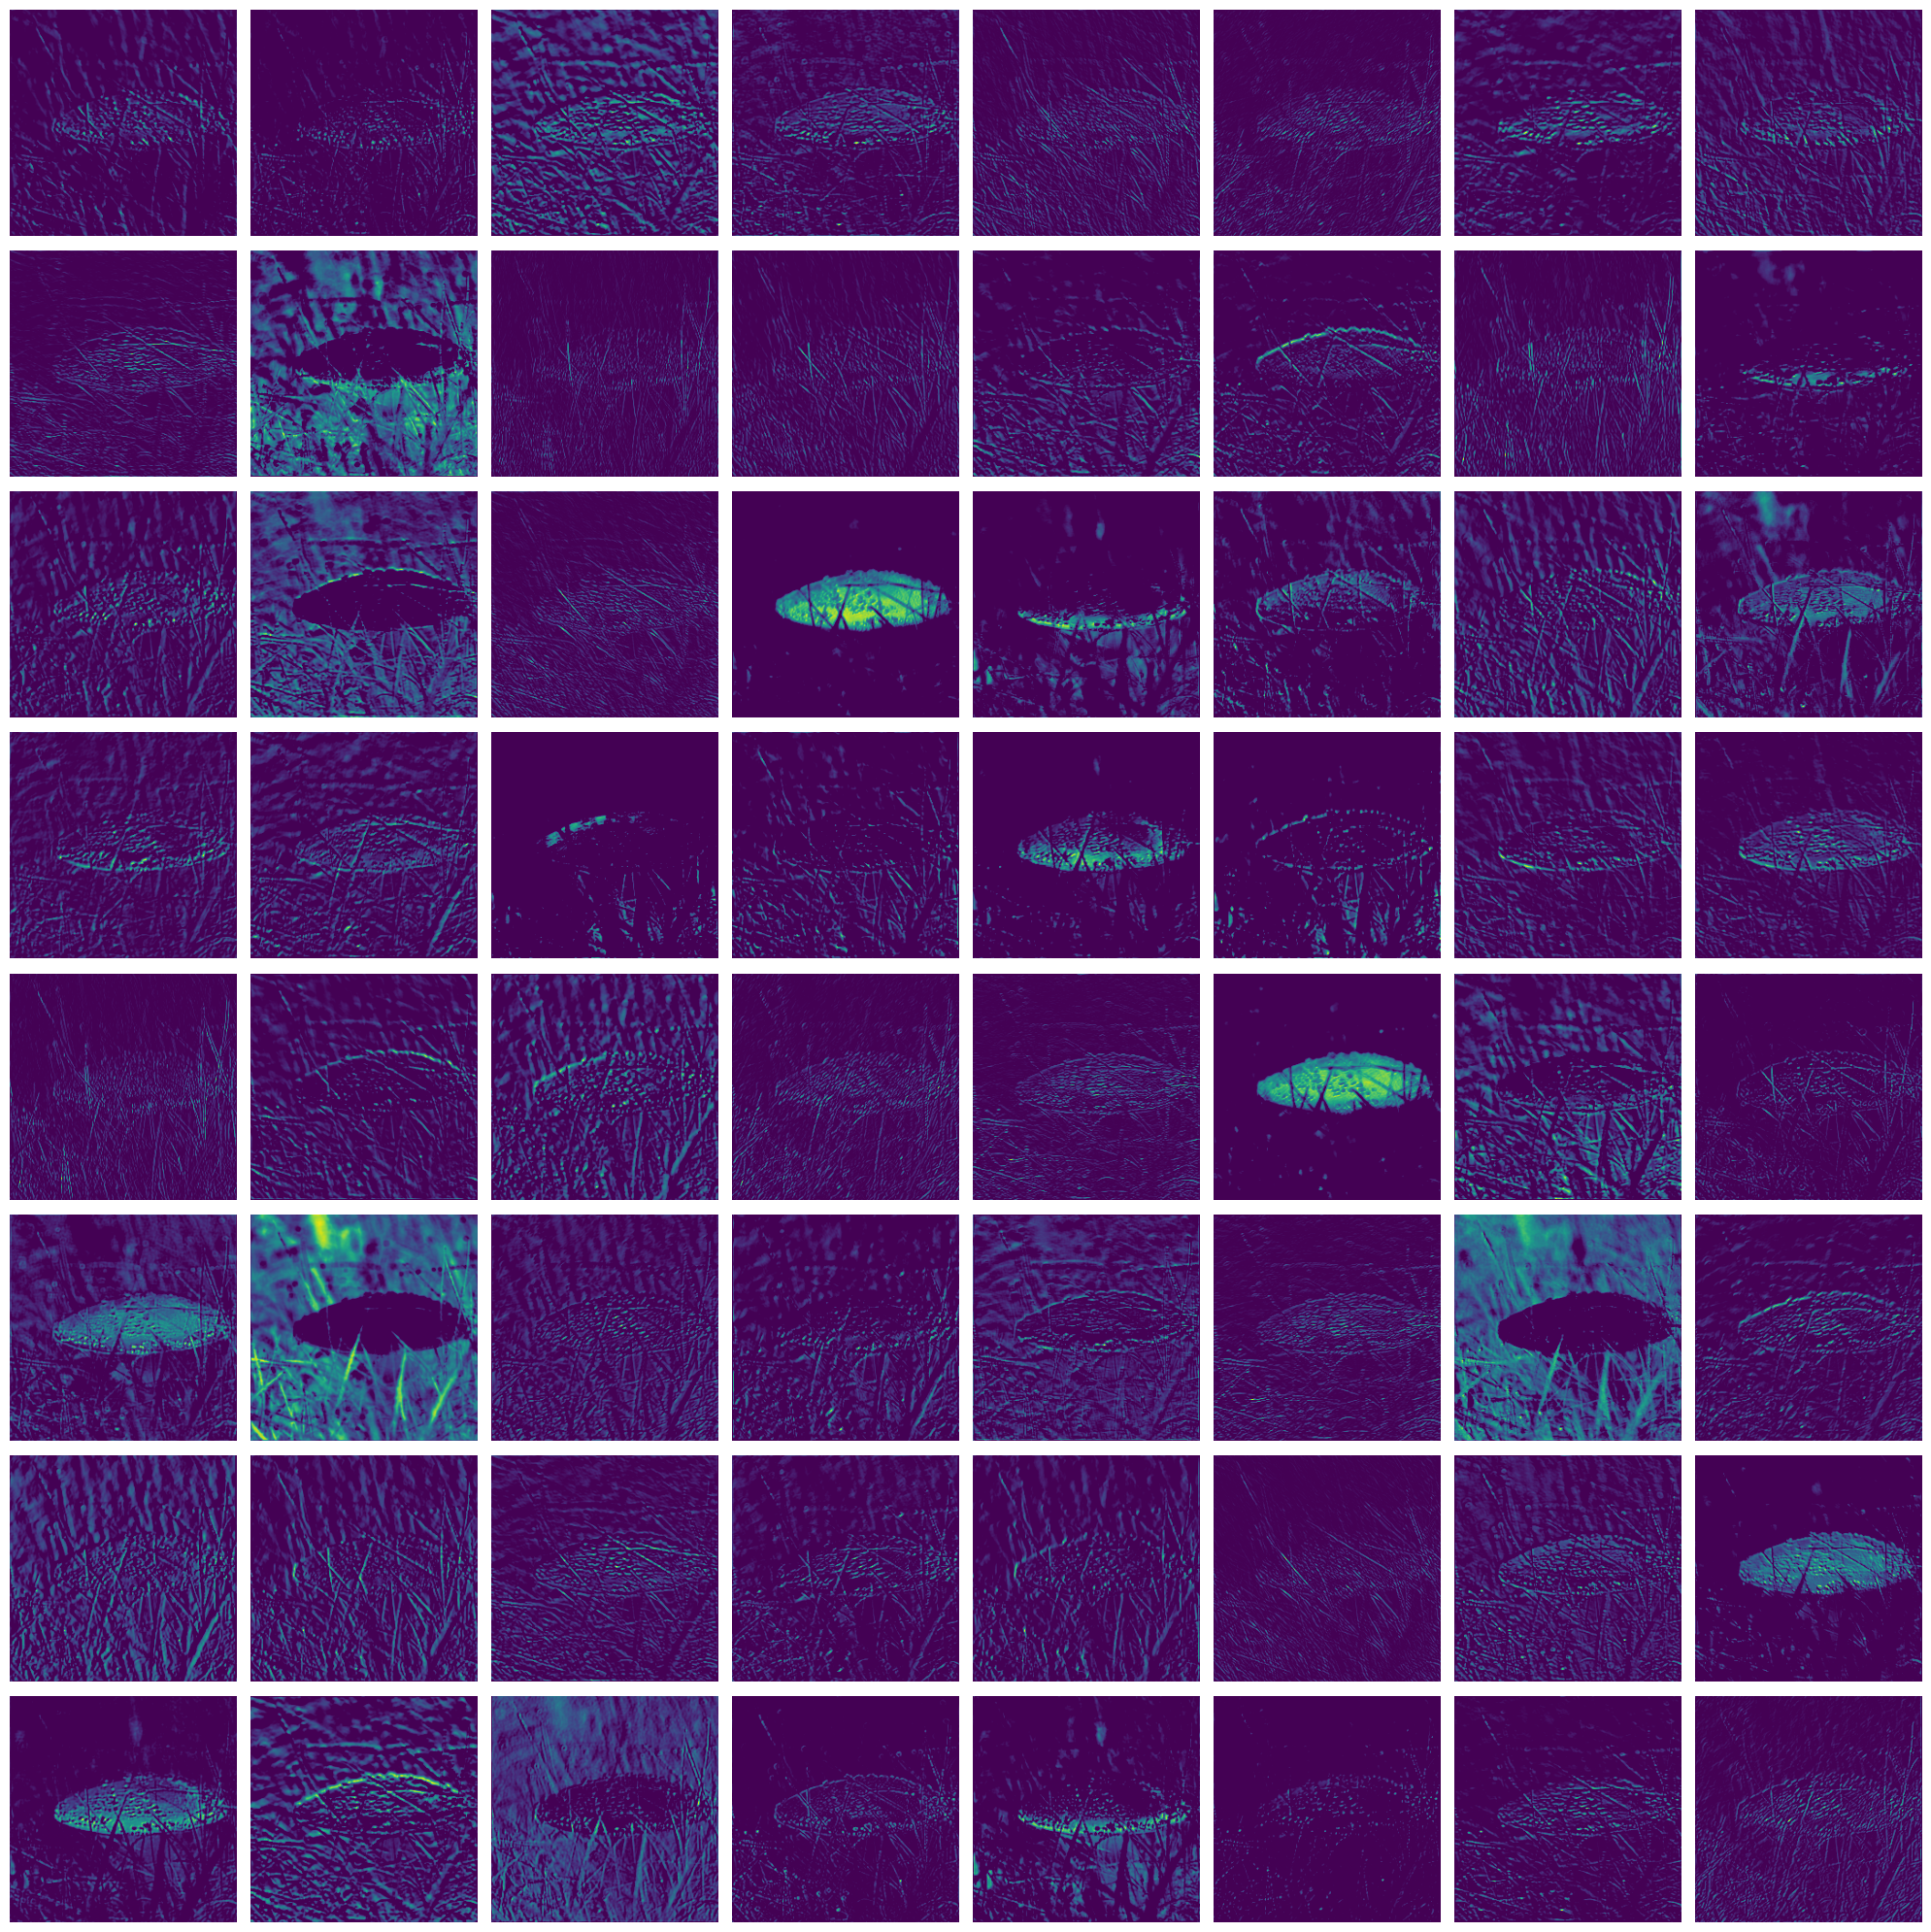

In [182]:
# Obtain Activations For Example
activations_example = activations[layer_name][0]

# Plotting 64 Activations
fig, axes = plt.subplots(8, 8, figsize = (20, 20)) 
for i, ax in enumerate(axes.flat):
    if i < 64:
        ax.imshow(activations_example[i].cpu().numpy(), cmap = 'viridis')
        ax.axis('off')
plt.tight_layout()
plt.show()

In [183]:
# Print Mean Activations
mean_activations = torch.mean(activations[layer_name], dim = (0, 2, 3))
print(mean_activations, mean_activations.shape)

tensor([0.4736, 0.1997, 1.0060, 0.3152, 0.5470, 0.4377, 0.3707, 0.3490, 0.5029,
        0.4095, 0.5749, 0.5256, 0.2631, 0.3290, 0.4948, 0.0962, 0.5961, 0.3031,
        0.5223, 0.4309, 0.4403, 0.5268, 0.8308, 0.1495, 0.3796, 0.6044, 0.1184,
        0.1698, 0.4040, 0.2139, 0.3364, 0.3775, 0.5181, 0.2660, 0.8548, 0.4783,
        0.6616, 0.3583, 0.4518, 0.3394, 1.0061, 1.7054, 0.5947, 0.2848, 0.4706,
        0.6049, 0.4925, 0.5752, 0.9258, 0.7562, 0.5037, 0.3047, 0.5001, 0.4637,
        0.5607, 0.6172, 1.1094, 0.9196, 0.6165, 0.3093, 0.4565, 0.1862, 0.4408,
        0.4908], device='cuda:0') torch.Size([64])


In [152]:
# Specify Paths (Imagenet)
imagenet_path = '/users/tdohm/work/Imagenet/train'

# Define Transformations
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(256),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]),
])

# Dictionary Storing Activation
activations = {}
def get_activation(name):
    def hook(model, input, output):
        activations[name] = output.detach()
    return hook

# Register Hook To Model
model.features[0].register_forward_hook(get_activation('features.14'))

# Initialization
mean_activations_by_class = {}
class_counter = defaultdict(int)
limit_per_class = 5
count_limit = 0

# Initialize TQDM Progress Bar
total_classes = len(os.listdir(imagenet_path))
pbar = tqdm(total = total_classes, desc = "Processing Classes")

# Iterate Over Class Folders In ImageNet Dataset
for idx, class_folder in enumerate(sorted(os.listdir(imagenet_path))):
    class_path = os.path.join(imagenet_path, class_folder)
    if not os.path.isdir(class_path):
        continue
    
    # Get Image Files From Class Folder
    image_files = [f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    
    # Randomly Select Some Images From Class Folder
    selected_images = random.sample(image_files, min(limit_per_class, len(image_files)))
    
    # Process Each Selected Image
    for image_file in selected_images:
        image_path = os.path.join(class_path, image_file)
        
        # Load, Preprocess Image
        image = Image.open(image_path).convert('RGB')
        image = transform(image).unsqueeze(0)
        
        # Move Image To Device
        image = image.to(device)
        
        # Forward Pass Through Model
        with torch.no_grad():
            _ = model(image)
        
        # Extract Mean Activation For Specified Layer
        # mean_activation = activations['features.14'].mean(dim = [2, 3]).cpu().numpy().flatten()[0]
        mean_activation = activations['features.14'][:, 2].cpu().mean().item()

        # Update Dictionary With Mean Activation For Current Class
        if class_folder in mean_activations_by_class:
            mean_activations_by_class[idx].append(mean_activation)
        else:
            mean_activations_by_class[idx] = [mean_activation]
    
    # Update Counter For Current Class
    class_counter[idx] += len(selected_images)
    
    # Update TQDM Progress Bar If Class Limit Reached
    if class_counter[idx] >= limit_per_class:
        count_limit += 1
    pbar.update(1)
    if count_limit >= 1000:
        break

# Close Bar
pbar.close()

Processing Classes: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:56<00:00,  5.67it/s]


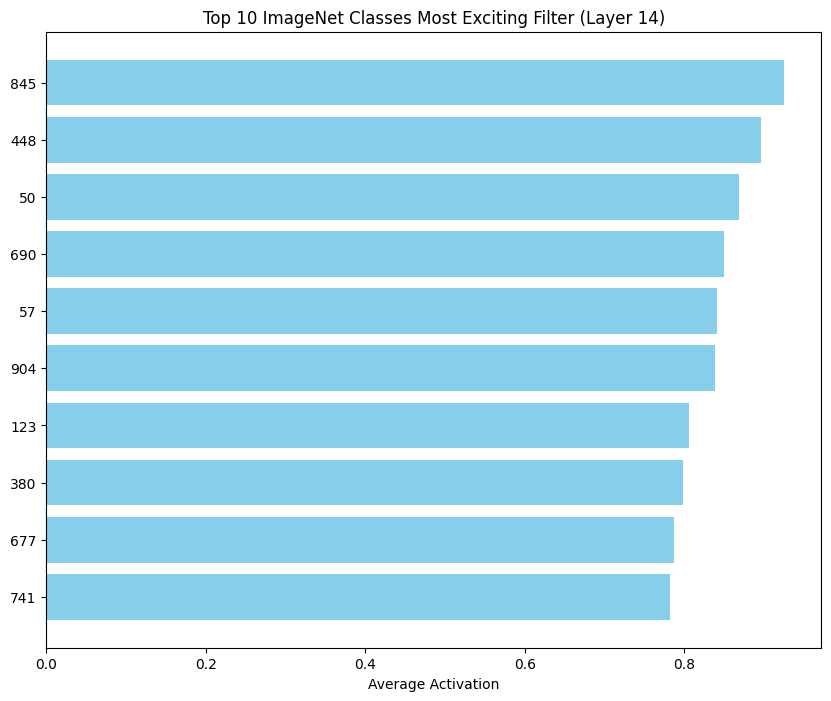

In [153]:
# Calculate Average Mean Activations For Each Class
average_activations = {class_id: np.mean(activations) for class_id, activations in mean_activations_by_class.items()}

# Sort Classes By Average Activation
sorted_classes_by_activation = sorted(average_activations.items(), key = lambda x: x[1], reverse = True)

# No. Top Classes
top_n = 10

# Obtain Top Classes By Mean Activation
top_classes = sorted_classes_by_activation[:top_n]

# Plotting
class_labels = [label for label, _ in top_classes]
activations = [activation for _, activation in top_classes]
plt.figure(figsize = (10, 8))
plt.barh(range(top_n), activations, color = 'skyblue')
plt.yticks(range(top_n), class_labels)
plt.gca().invert_yaxis()
plt.xlabel('Average Activation')
plt.title(f'Top {top_n} ImageNet Classes Most Exciting Filter (Layer 14)')
plt.show()

In [157]:
# Define Path To Text File
txt_file_path = '/users/tdohm/work/Advanced-Deep-Learning-Projects/lab3_cnn_visualization/imagenet_2012_clsidx_to_labels.txt' 

# Load Class ID To Label Mapping
id_to_label = {}
with open(txt_file_path, 'r') as file:
    content = file.read()
    id_to_label = ast.literal_eval(content)

# Retrieve Labels For Classes
classes = [id_to_label.get(class_id) for class_id in class_labels]

# Print Retrieved Labels
for class_id, label in zip(class_labels, classes):
    print(f"Class ID: {class_id}, Label: {label}")

Class ID: 845, Label: syringe
Class ID: 448, Label: birdhouse
Class ID: 50, Label: American alligator, Alligator mississipiensis
Class ID: 690, Label: oxcart
Class ID: 57, Label: garter snake, grass snake
Class ID: 904, Label: window screen
Class ID: 123, Label: spiny lobster, langouste, rock lobster, crawfish, crayfish, sea crawfish
Class ID: 380, Label: titi, titi monkey
Class ID: 677, Label: nail
Class ID: 741, Label: prayer rug, prayer mat


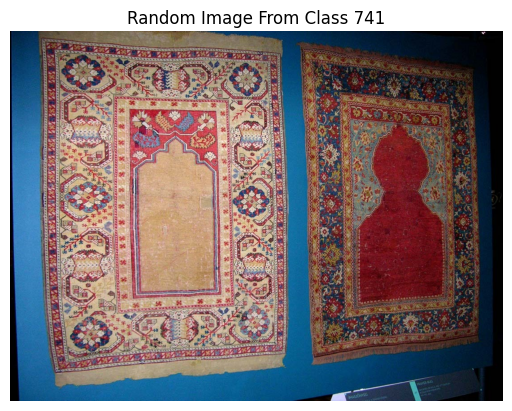

In [208]:
# Specify Training Data Path
imagenet_train_path = '/users/tdohm/work/Imagenet/train'

# Specify Class Index
class_index_to_retrieve = 741

# Get All Class Subdirectories, Sort
class_directories = sorted([d for d in os.listdir(imagenet_train_path) if os.path.isdir(os.path.join(imagenet_train_path, d))])

# Access Subdirectory For Specified Class Index
if class_index_to_retrieve < len(class_directories):
    class_folder_path = os.path.join(imagenet_train_path, class_directories[class_index_to_retrieve])
    
    # Get All Image Files In Class Folder
    image_files = [f for f in os.listdir(class_folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    
    # Select Random Example
    if image_files:
        random_image_name = random.choice(image_files)
        random_image_path = os.path.join(class_folder_path, random_image_name)
        
        # Open, Display Random Images
        with Image.open(random_image_path) as img:
            plt.imshow(img)
            plt.title(f'Random Image From Class {class_index_to_retrieve}')
            plt.axis('off')
            plt.show()
            
    else:
        print(f"No Images Found: {class_folder_path}")
else:
    print(f"Class Index {class_index_to_retrieve} Out Of Range")
